In [2]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Data Pre-processing

In [3]:
df = pd.read_csv('./1_Bitcoin.csv')
df.shape
# data preprocee
df=df.applymap(lambda x: x.replace('$',''))
df=df.applymap(lambda x: x.replace(',',''))
cl = ['Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']
for c in cl:
    df[c] = df[c].astype(float)

df = df.rename(columns={'Open*': 'Open', 'Close**': 'Close'})
df = df[::-1]
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
3041,Jul 02 2013,88.05,92.30,87.51,90.13,0.0,1.024082e+09
3040,Jul 03 2013,90.40,90.98,76.98,77.53,0.0,8.812331e+08
3039,Jul 04 2013,78.89,83.11,72.00,80.53,0.0,9.156186e+08
3038,Jul 05 2013,79.99,80.00,65.53,68.43,0.0,7.784112e+08
3037,Jul 06 2013,68.50,75.00,66.82,70.28,0.0,7.997416e+08


The data representation where we group trades by the predefined time interval is called time bars.
https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

In [4]:
df = df.loc[:, ['Close','Open', 'High', 'Low', 'Volume']]
df.shape

(3042, 5)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

scaled_data = scaled_data.astype(np.float32)
scaled_data.shape

(3042, 5)

In [6]:
def transform_data(arr, seq_len):
    data_X = []
    data_y = []
    for i in range(0, arr.shape[0] - seq_len):
        data_X.append(arr[i:i+seq_len, :].copy())
        data_y.append(arr[i+seq_len, 3])
    data_X = np.stack(data_X, axis=0)
    data_y = np.array(data_y).reshape(-1, 1)
    return data_X, data_y

In [7]:
# set time_stamp
time_stamp = 5

# transfrom data
X_data, y_data = transform_data(scaled_data, time_stamp)
X_data.shape, y_data.shape

((3037, 5, 5), (3037, 1))

In [8]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        return self.X[i, :, :], self.y[i]

In [9]:
data_cnt = y_data.shape[0]
X_train = X_data[0:int(data_cnt * 0.6), :]
y_train = y_data[0:int(data_cnt * 0.6), :]

X_valid = X_data[int(data_cnt * 0.6):int(data_cnt * 0.8), :]
y_valid = y_data[int(data_cnt * 0.6):int(data_cnt * 0.8), :]

X_test = X_data[int(data_cnt * 0.8):, :]
y_test = y_data[int(data_cnt * 0.8):, :]

df_valid = df.iloc[int(data_cnt * 0.6): int(data_cnt * 0.8), :]
df_test = df.iloc[int(data_cnt * 0.8) + 1:, :]

print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_valid', X_valid.shape, 'y_valid', y_valid.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

X_train (1822, 5, 5) y_train (1822, 1)
X_valid (607, 5, 5) y_valid (607, 1)
X_test (608, 5, 5) y_test (608, 1)


## Model

In [10]:
# set batch_size
batch_size = 64

In [11]:
train_data = SequenceDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)

valid_data = SequenceDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)

test_data = SequenceDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=True)

In [12]:
class Model(nn.Module):
    def __init__(self, rnn_type, input_dim, hidden_dim, num_layers, output_dim):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, hidden=None):
        
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden


In [13]:
model =  Model('gru', 5, 128, 2, 1)
model

Model(
  (rnn): GRU(5, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)

In [14]:
# param
epoch = 300
lr = 0.00001
loss_function = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [15]:
train_avg_lst = []
val_avg_lst = []

device = torch.device('cpu') if torch.cuda.is_available else torch.device('cpu')

model = model.to(device)


for epoch in range(epoch):  
    train_total_loss = []
    
    for train_batch_x, train_batch_y in train_dataloader:
        train_batch_x = train_batch_x.to(device)
        train_batch_y = train_batch_y.to(device)
        
        # Clear them out Pytorch accumulated gradients before each instance
        model.zero_grad()

        # Run forward pass
        train_out, _ = model(train_batch_x)

        # Compute the loss, gradients, and update the parameters by calling optimizer.step()
        
        # loss function
        train_loss = loss_function(train_out, train_batch_y)
        
        # backward
        train_loss.backward()
        
        # opt
        optimizer.step()
        
        # add loss
        np_train_loss = train_loss.item()
        train_total_loss.append(np_train_loss)
    
    # scheduler
    #scheduler.step()
    
    train_avg_loss = sum(train_total_loss) / len(train_total_loss)


    val_total_loss = []
    with torch.no_grad():
        for val_batch_x, val_batch_y in valid_dataloader:
            val_batch_x = val_batch_x.to(device)
            val_batch_y = val_batch_y.to(device)
            
            val_out, _ = model(val_batch_x)
            
            val_loss = loss_function(val_out, val_batch_y)
            np_val_loss = val_loss.item()
            val_total_loss.append(np_val_loss)
    
    val_avg_loss = sum(val_total_loss) / len(val_total_loss)
    
    print("Epoch {0}, train MSE: {1:.6f}, valid MSE: {2:.6f}".format(epoch, train_avg_loss, val_avg_loss))
    train_avg_lst.append(train_avg_loss)
    val_avg_lst.append(val_avg_loss)

Epoch 0, train MSE: 0.003216, valid MSE: 0.011591
Epoch 1, train MSE: 0.002868, valid MSE: 0.010117
Epoch 2, train MSE: 0.002735, valid MSE: 0.009206
Epoch 3, train MSE: 0.002681, valid MSE: 0.008638
Epoch 4, train MSE: 0.002651, valid MSE: 0.008266
Epoch 5, train MSE: 0.002628, valid MSE: 0.008009
Epoch 6, train MSE: 0.002606, valid MSE: 0.007821
Epoch 7, train MSE: 0.002584, valid MSE: 0.007676
Epoch 8, train MSE: 0.002561, valid MSE: 0.007557
Epoch 9, train MSE: 0.002537, valid MSE: 0.007454
Epoch 10, train MSE: 0.002514, valid MSE: 0.007361
Epoch 11, train MSE: 0.002490, valid MSE: 0.007275
Epoch 12, train MSE: 0.002466, valid MSE: 0.007194
Epoch 13, train MSE: 0.002442, valid MSE: 0.007115
Epoch 14, train MSE: 0.002418, valid MSE: 0.007038
Epoch 15, train MSE: 0.002394, valid MSE: 0.006963
Epoch 16, train MSE: 0.002370, valid MSE: 0.006888
Epoch 17, train MSE: 0.002346, valid MSE: 0.006815
Epoch 18, train MSE: 0.002322, valid MSE: 0.006741
Epoch 19, train MSE: 0.002298, valid MSE:

Epoch 160, train MSE: 0.000036, valid MSE: 0.000045
Epoch 161, train MSE: 0.000036, valid MSE: 0.000045
Epoch 162, train MSE: 0.000036, valid MSE: 0.000046
Epoch 163, train MSE: 0.000036, valid MSE: 0.000046
Epoch 164, train MSE: 0.000036, valid MSE: 0.000046
Epoch 165, train MSE: 0.000036, valid MSE: 0.000046
Epoch 166, train MSE: 0.000036, valid MSE: 0.000046
Epoch 167, train MSE: 0.000036, valid MSE: 0.000046
Epoch 168, train MSE: 0.000036, valid MSE: 0.000046
Epoch 169, train MSE: 0.000036, valid MSE: 0.000046
Epoch 170, train MSE: 0.000036, valid MSE: 0.000046
Epoch 171, train MSE: 0.000036, valid MSE: 0.000046
Epoch 172, train MSE: 0.000036, valid MSE: 0.000046
Epoch 173, train MSE: 0.000036, valid MSE: 0.000046
Epoch 174, train MSE: 0.000036, valid MSE: 0.000046
Epoch 175, train MSE: 0.000036, valid MSE: 0.000046
Epoch 176, train MSE: 0.000036, valid MSE: 0.000046
Epoch 177, train MSE: 0.000036, valid MSE: 0.000046
Epoch 178, train MSE: 0.000036, valid MSE: 0.000046
Epoch 179, t

In [16]:
pred_test_y = []

with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
        batch_x = batch_x.to(device)
        
        pred_y, _ = model(batch_x)
        np_pred_y = pred_y.cpu().detach().numpy()
        pred_test_y.append(np_pred_y)

In [17]:
pred_test_y = np.concatenate(pred_test_y)
pred_test_y.shape

(608, 1)

In [18]:
# inverse transform pred
pred_test_y_inverse0 = scaler.inverse_transform(pred_test_y.repeat(5, axis=1))
pred_test_y_inverse = pred_test_y_inverse0[:, 3:5]
pred_test_y_inverse.shape

(608, 2)

In [19]:
# inverse transform gt
y_test_inverse0 = scaler.inverse_transform(y_test.repeat(5, axis=1))
y_test_inverse = y_test_inverse0[:, 3:5]
y_test_inverse.shape

(608, 2)

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

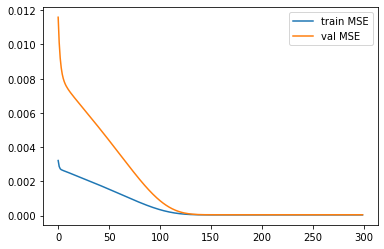

In [21]:
# draw loss
x_axis = np.arange(len(train_avg_lst))
plt.plot(x_axis, train_avg_lst, label='train MSE')
plt.plot(x_axis, val_avg_lst, label='val MSE')
plt.legend()
plt.show()

In [22]:
pred_test_y_inverse.shape

(608, 2)

## Model Report

In [23]:
MAPE = mean_absolute_percentage_error(pred_test_y_inverse, y_test_inverse)
print("The mean absolute percentage error for the GRU is: %2f"%MAPE)

The mean absolute percentage error for the GRU is: 0.061094


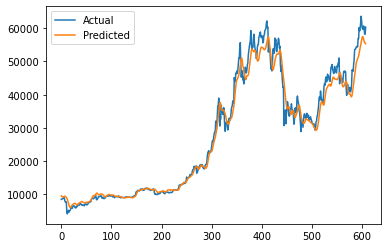

In [24]:

x_axis = np.arange(pred_test_y_inverse.shape[0])
plt.plot(x_axis, y_test_inverse[:, 0], label='Actual')
plt.plot(x_axis, pred_test_y_inverse[:, 0], label='Predicted')
plt.legend()
plt.show()

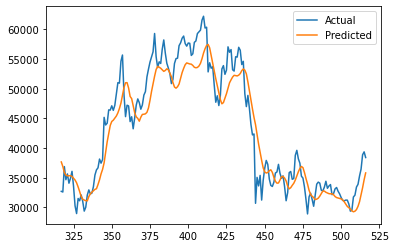

In [25]:
x_axis = np.arange(317,517)
plt.plot(x_axis, y_test_inverse[317:517, 0], label='Actual')
plt.plot(x_axis, pred_test_y_inverse[317:517, 0], label='Predicted')
plt.legend()
plt.show()